In [28]:

import pandas as pd
import datetime as dt
import datetime
import csv
import numpy as np

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

import os

eth_opt = Options('ETH')
btc_opt = Options('BTC')
eth_hdata = HistData('ETH')
btc_hdata = HistData('BTC')

btc_spot = btc_hdata.get_idx_price()
eth_spot = eth_hdata.get_idx_price()

ethpath =os.path.join(os.getcwd(),'data/eth_hist_option_chain.csv') 
btcpath =os.path.join(os.getcwd(),'data/btc_hist_option_chain.csv')



eth_options = eth_opt.get_full_option_chain(eth_spot)
btc_options = btc_opt.get_full_option_chain(btc_spot)

816 active options.
816 active options.
1727424000000
Expiration Date:  2024-12-27 16:00:00
816 active options.
1717142400000
Expiration Date:  2024-06-28 16:00:00
816 active options.
1719561600000
Expiration Date:  2024-09-27 16:00:00
816 active options.
1743148800000
2025-03-28 08:00:00 date options failed
816 active options.
1714118400000
Expiration Date:  2024-05-31 16:00:00
816 active options.
1735286400000
Expiration Date:  2025-03-28 16:00:00
816 active options.
1712822400000
Expiration Date:  2024-04-12 16:00:00
816 active options.
1712908800000
Expiration Date:  2024-04-13 16:00:00
816 active options.
1713513600000
Expiration Date:  2024-04-26 16:00:00
816 active options.
816 active options.
1727424000000
Expiration Date:  2024-12-27 16:00:00
816 active options.
1717142400000
Expiration Date:  2024-06-28 16:00:00
816 active options.
1719561600000
Expiration Date:  2024-09-27 16:00:00
816 active options.
1743148800000
2025-03-28 08:00:00 date options failed
816 active options.


In [6]:
import os
os.getcwd()

'c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\Volatility Arbitrage'

In [17]:
pd.datetime.today().strftime('%Y%m%d')+'.xlsx'

'20240410.xlsx'

In [23]:
eth_path = r"C:\Users\kmavy\Documents\mydocs\Training Arc\Github\QuantMasterFund\Crypto\data\eth_opt_chain_"+pd.datetime.today().strftime('%Y%m%d')+'.xlsx'
btc_path = r"C:\Users\kmavy\Documents\mydocs\Training Arc\Github\QuantMasterFund\Crypto\data\btc_opt_chain_"+pd.datetime.today().strftime('%Y%m%d')+'.xlsx'

In [24]:
eth_options.to_excel(eth_path)
btc_options.to_excel(btc_path)

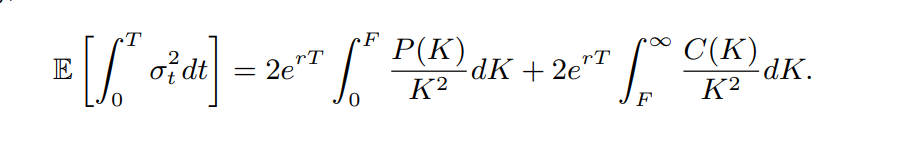

## Static Replication of Variance Swap


$$V_{var} = 2e^{rt}\int^{F}_0 \frac{P(K)}{K^2}dK + 2e^{rt} \int^{\infty}_{F} \frac{C(K)}{K^2} dK$$

In [62]:
def derive_var_swap(data,tte,r):
    curr_dt = pd.datetime.today()
    data['strike'] = data['strike'].astype(float)
    data['dte'] =data['dte'].astype(float)
    tte = data.iloc[(data['dte']-tte).abs().argsort()]['dte'][0]
    data = data[data['dte']==tte]

    ##Integral
    rt = (tte * r)/365
    F = float(data['spot'].iloc[0])*np.exp(rt)
    #Call Integral
    calls = data[(data['strike']>=F)&(data['option_type']=='call')]
    calls['dK'] = (calls['strike'].diff().fillna(0) + abs(calls['strike'].diff(-1).fillna(0)))/2
    call_int =(calls['mark_price_usd']/(calls['strike'])**2) * calls['dK']
    call_int = sum(call_int)

    #Put Integral
    puts = data[(data['strike']<=F)&(data['option_type']=='put')]
    puts['dK'] = (puts['strike'].diff().fillna(0) + abs(puts['strike'].diff(-1).fillna(0)))/2
    put_int =(puts['mark_price_usd']/(puts['strike'])**2) * puts['dK']
    put_int = sum(put_int)

    print(put_int,call_int)

    
    return 2*np.exp(rt)*(call_int+put_int)



In [86]:
def derive_var_swap(data,tte,r):
    curr_dt = pd.datetime.today()
    data['strike'] = data['strike'].astype(float)
    data['dte'] =data['dte'].astype(float)
    tte = data.iloc[(data['dte']-tte).abs().argsort()]['dte'][0]
    data = data[data['dte']==tte]

    ##Integral
    rt = (tte * r)/365
    F = float(data['spot'].iloc[0])*np.exp(rt)
    #Call Integral
    calls = data[(data['strike']>=F)&(data['option_type']=='call')]
    calls['dK'] = (calls['strike'].diff().fillna(0) + abs(calls['strike'].diff(-1).fillna(0)))/2

    call_int =(calls['mark_price_usd']/(calls['strike'])**2) * calls['dK'] 
    call_int = sum(call_int)

    #Put Integral
    puts = data[(data['strike']<=F)&(data['option_type']=='put')]
    puts['dK'] = (puts['strike'].diff().fillna(0) + abs(puts['strike'].diff(-1).fillna(0)))/2
    put_int =(puts['mark_price_usd']/(puts['strike'])**2) * puts['dK'] 
    put_int = sum(put_int)

    return 2*np.exp(rt)*(call_int+put_int)/tte



In [87]:
derive_var_swap(eth_options,1,0.05)

0.1707471718040425

In [88]:
ivols = {}
for tte in sorted(set(eth_options['dte'])):
    ivols[tte]=np.sqrt((derive_var_swap(eth_options,tte,0.05)))

In [90]:
ivols

{1.0: 0.41321564806290006,
 2.0: 0.12489030685235805,
 15.0: 0.28616150539431845,
 50.0: 0.13778558649952752,
 78.0: 0.6471991179409989,
 169.0: 0.4449417872244866,
 260.0: 0.22528389242808544,
 351.0: 0.10372974296113902}

In [92]:
vswap = pd.DataFrame(ivols.values(),index = ivols.keys()).T
vswap.index = [pd.datetime.today().strftime("%Y-%m-%d")]

In [93]:
vswap

,1.0,2.0,15.0,50.0,78.0,169.0,260.0,351.0
2024-04-10,0.413216,0.12489,0.286162,0.137786,0.647199,0.444942,0.225284,0.10373


In [115]:
indices = [float(t) for t in np.arange(0,366,5)]

In [120]:
vswap = pd.concat([vswap.T,pd.DataFrame(index = indices)],axis=1).sort_index().interpolate().fillna(0).T

In [121]:
vswap

,0.0,1.0,2.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,...,325.0,330.0,335.0,340.0,345.0,350.0,351.0,355.0,360.0,365.0
2024-04-10,0.0,0.413216,0.12489,0.178647,0.232404,0.286162,0.264965,0.243768,0.222572,0.201375,...,0.142115,0.135718,0.12932,0.122923,0.116525,0.110127,0.10373,0.10373,0.10373,0.10373


In [30]:
derive_var_swap(eth_options,30,0.05)

1.2302470992797685